In [1]:
import meep as mp
import matplotlib.pyplot as plt

resolution = 25  # pixels/μm

w1 = 1.0  # width of waveguide 1
w2 = 2.0  # width of waveguide 2
Lw = 10.0  # length of waveguides 1 and 2

# lengths of waveguide taper
Lts = [2**m for m in range(4)]

dair = 3.0  # length of air region
dpml_x = 6.0  # length of PML in x direction
dpml_y = 2.0  # length of PML in y direction

sy = dpml_y + dair + w2 + dair + dpml_y

Si = mp.Medium(epsilon=12.0)

boundary_layers = [mp.PML(dpml_x, direction=mp.X), mp.PML(dpml_y, direction=mp.Y)]

lcen = 6.67  # mode wavelength
fcen = 1 / lcen  # mode frequency

symmetries = [mp.Mirror(mp.Y)]

R_coeffs = []
R_flux = []

for Lt in Lts:
    sx = dpml_x + Lw + Lt + Lw + dpml_x
    cell_size = mp.Vector3(sx, sy, 0)

    src_pt = mp.Vector3(-0.5 * sx + dpml_x + 0.2 * Lw)
    sources = [
        mp.EigenModeSource(
            src=mp.GaussianSource(fcen, fwidth=0.2 * fcen),
            center=src_pt,
            size=mp.Vector3(y=sy - 2 * dpml_y),
            eig_match_freq=True,
            eig_parity=mp.ODD_Z + mp.EVEN_Y,
        )
    ]

    # straight waveguide
    vertices = [
        mp.Vector3(-0.5 * sx - 1, 0.5 * w1),
        mp.Vector3(0.5 * sx + 1, 0.5 * w1),
        mp.Vector3(0.5 * sx + 1, -0.5 * w1),
        mp.Vector3(-0.5 * sx - 1, -0.5 * w1),
    ]

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=[mp.Prism(vertices, height=mp.inf, material=Si)],
        sources=sources,
        symmetries=symmetries,
    )

    mon_pt = mp.Vector3(-0.5 * sx + dpml_x + 0.7 * Lw)
    flux = sim.add_flux(
        fcen, 0, 1, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy - 2 * dpml_y))
    )

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

    res = sim.get_eigenmode_coefficients(flux, [1], eig_parity=mp.ODD_Z + mp.EVEN_Y)
    incident_coeffs = res.alpha
    incident_flux = mp.get_fluxes(flux)
    incident_flux_data = sim.get_flux_data(flux)

    sim.reset_meep()

    # linear taper
    vertices = [
        mp.Vector3(-0.5 * sx - 1, 0.5 * w1),
        mp.Vector3(-0.5 * Lt, 0.5 * w1),
        mp.Vector3(0.5 * Lt, 0.5 * w2),
        mp.Vector3(0.5 * sx + 1, 0.5 * w2),
        mp.Vector3(0.5 * sx + 1, -0.5 * w2),
        mp.Vector3(0.5 * Lt, -0.5 * w2),
        mp.Vector3(-0.5 * Lt, -0.5 * w1),
        mp.Vector3(-0.5 * sx - 1, -0.5 * w1),
    ]

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=[mp.Prism(vertices, height=mp.inf, material=Si)],
        sources=sources,
        symmetries=symmetries,
    )

    flux = sim.add_flux(
        fcen, 0, 1, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy - 2 * dpml_y))
    )
    sim.load_minus_flux_data(flux, incident_flux_data)

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

    res2 = sim.get_eigenmode_coefficients(flux, [1], eig_parity=mp.ODD_Z + mp.EVEN_Y)
    taper_coeffs = res2.alpha
    taper_flux = mp.get_fluxes(flux)

    R_coeffs.append(
        abs(taper_coeffs[0, 0, 1]) ** 2 / abs(incident_coeffs[0, 0, 0]) ** 2
    )
    R_flux.append(-taper_flux[0] / incident_flux[0])
    print("refl:, {}, {:.8f}, {:.8f}".format(Lt, R_coeffs[-1], R_flux[-1]))

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.068943 s
Working in 2D dimensions.
Computational cell is 33 x 12 x 0 with resolution 25
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-17.5,0.5,0)
          (17.5,0.5,0)
          (17.5,-0.5,0)
          (-17.5,-0.5,0)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.387602 s
-----------
MPB solved for frequency_1(0.519356,0,0) = 0.176186 after 9 iters
MPB solved for frequency_1(0.424206,0,0) = 0.149878 after 7 iters
MPB solved for frequency_1(0.424377,0,0) = 0.149925 after 5 iters
MPB solved for frequency_1(0.424377,0,0) = 0.149925 after 1 iters
field decay(t = 50.02): 7.547409317790427e-08 / 7.547409317790427e-08 = 1.0
on time step 4594 (time=91.88), 0.0008708 s/step
field decay(t = 100.04): 0.00173561428225222 / 0.00173561428225222 = 1.0
field decay(t = 150.0

     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 8 vertices:
          (-21,0.5,0)
          (-4,0.5,0)
          (4,1,0)
          (21,1,0)
          (21,-1,0)
          (4,-1,0)
          (-4,-0.5,0)
          (-21,-0.5,0)
          dielectric constant epsilon diagonal = (12,12,12)


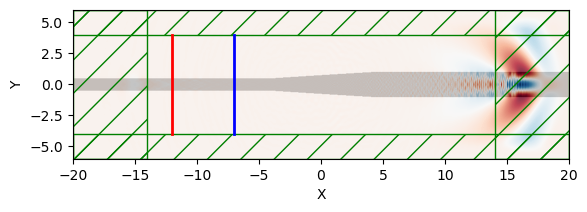

In [5]:
plt.figure(dpi=100)
sim.plot2D(fields = mp.Ez)
plt.show()

In [6]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [8]:


sim.run(mp.at_every(1, Animate), until=100)
plt.close()



FloatProgress(value=100.0, description='0% done ', max=200.0, min=100.0)

on time step 5000 (time=100), 0.0750982 s/step
Meep progress: 49.860000000000014/200.0 = 24.9% done in 4.0s, 12.0s to go
on time step 7513 (time=150.26), 0.00159176 s/step
Normalizing field data...
run 1 finished at t = 200.0 (10000 timesteps)


In [9]:
filename = "tapered_waveguide.mp4"
Animate.to_mp4(10, filename)

Generating MP4...


In [10]:
from IPython.display import Video

Video(filename)